In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install ml-collections

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 4.4 MB/s eta 0:00:00


In [3]:
%cd "/content/drive/MyDrive/FYP/TCT code/vit-visual-search/notebooks"

# _________ APPEND SOME PATH TO IMPORT SOME LIBRARY BELOW _____________
import sys

sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../irl_dcb')
sys.path.append('../../irl_dcb/irl_dcb')

# _________ APPEND SOME PATH TO IMPORT SOME LIBRARY BELOW _____________

/content/drive/MyDrive/FYP/TCT code/vit-visual-search/notebooks


In [4]:
import os

if os.path.exists('/src'):
    os.unlink('/src')
os.symlink(os.path.abspath('../..'), '/src') # link TCT code folder with /src folder

In [5]:
import zipfile
import shutil



# Specify the path to your zip file
zip_file_path = '/src/coco18_search/coco-search18_dataset.zip'

# Specify the destination directory where you want to extract the contents
# If not provided, it extracts to the current working directory.
destination_directory = '/src/coco18_search/'

# Create the destination directory if it doesn't exist
if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)

if not os.path.exists(os.path.join(destination_directory, 'coco-search18_dataset')):
    print('Unzip file not found start unzipping!')

    try:
        # Open the zip file in read mode ('r')
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            # Extract all the contents to the specified destination directory
            zip_ref.extractall(destination_directory)
        print(f"Successfully unzipped '{zip_file_path}' to '{destination_directory}'")
    except zipfile.BadZipFile:
        print(f"Error: '{zip_file_path}' is not a valid ZIP file.")
    except FileNotFoundError:
        print(f"Error: ZIP file '{zip_file_path}' not found.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
else:
    print('Unzip dataset file found!')

if not os.path.exists(os.path.join(destination_directory, 'coco-search18_dataset', 'image_info.pkl')):
    source_file = os.path.join(destination_directory, 'image_info.pkl')
    destination_file = os.path.join(destination_directory, 'coco-search18_dataset', 'image_info.pkl')

    shutil.copyfile(source_file, destination_file)
    print(f"File '{source_file}' copied to '{destination_file}' (contents only).")

if not os.path.exists(os.path.join(destination_directory, 'coco-search18_dataset', 'random_filenames_pairs_0915.pkl')):
    source_file = os.path.join(destination_directory, 'random_filenames_pairs_0915.pkl')
    destination_file = os.path.join(destination_directory, 'coco-search18_dataset', 'random_filenames_pairs_0915.pkl')

    shutil.copyfile(source_file, destination_file)
    print(f"File '{source_file}' copied to '{destination_file}' (contents only).")

Unzip dataset file found!


In [6]:
import json
import numpy as np
import torch
from os.path import join
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
import seaborn as sns
from itertools import product
from PIL import Image
# import cv2
from tqdm import tqdm
import pickle
from torch.utils.data import Dataset, DataLoader
from glob import glob


import dataset
from tasks.visual_search1 import *
from irl_dcb.utils import *
from torchvision import transforms
from data.coco18 import coco18

In [7]:
device = (
    "cuda" if torch.cuda.is_available()
    else "mps"  # macbook uses metal performance shaders to GPU accelearation
    if torch.backends.mps.is_available()
    else "cpu"
)

search_w = 512
search_h = 320
target_min = 128
patch_w = 16
patch_h = 16
n_patch_w, n_patch_h = int(search_w // patch_w), int(search_h // patch_h)
IOR_size = 24
dataset = 'coco18'
n_random = 100

if dataset == 'coco18':
    # MIX4: ZR+RR+RZ+ZZ with the fixed search/target pairs
    with open('/src/vit-visual-search/context/CRT_coco18test_modelmix4ZR_original_1008.pkl', 'rb') as handle:
        crt_attn = pickle.load(handle)
    # test_traj = json.load(open('/src/coco-search18_dataset/processed/coco_search18_fixations_TP_test.json'))
    test_traj = json.load(open('/src/coco-search18_dataset/processed/human_scanpaths_TP_trainval_valid.json'))
    tasks = np.unique(pd.DataFrame(test_traj)['task'].values)

elif dataset == 'natural-design':
    with open('/src/vit-visual-search/context/CRT_naturaldesign_modelmix4ZR_original_1008.pkl', 'rb') as handle:
        crt_attn = pickle.load(handle)

elif dataset == 'scegram':
    with open('/src/vit-visual-search/context/CRT_SCEGRAM_modelmix4ZR_original_1008.pkl', 'rb') as handle:
        crt_attn = pickle.load(handle)


In [8]:
vit = load_model(device=device)
vit.to(device)

VisionTransformer(
  (transformer): Transformer(
    (embeddings): Embeddings(
      (patch_embeddings): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): Encoder(
      (layer): ModuleList(
        (0-11): 12 x Block(
          (attention_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (attn): Attention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (out): Linear(in_features=768, out_features=768, bias=Tru

In [9]:
dataset_dir = '/src/coco18_search/coco-search18_dataset'

In [10]:
task_result = {}

for i, task in enumerate(tqdm(tasks)):
    result = dict()

    dset_config = dict(dataset_dir = dataset_dir, task=task, search_size=(search_h, search_w), target_size=(0, 0), per_target=True, is_transform=True)
    dset = coco18(**dset_config)

    for i in tqdm(range(len(dset))):
        name = dset.image_info[dset.task]['names'][i]
        key = task + '_' + name

        if key not in crt_attn.keys():
            continue

        result[key] = dict()
        temp = result[key]
        s_im, t_im, solution, t_bbox = dset.__getitem__(i)

        # Task 0: random search
        rands = []
        for n in range(n_random):
            np.random.seed(int(i + 1e3 + n))
            rand_attn = np.random.rand(search_h, search_w)
            attn = add_init_fix(rand_attn, search_w, search_h)
            rand_path_rel = search_task(attn, solution, inh_size=IOR_size, fix_method='relaxed')
            rands.append(rand_path_rel)
        temp['rand_path_rel'] = rands

        # Task 1: CRT alone
        crt_tensor = crt_attn[key]
        norm_crt_tensor = crt_tensor / crt_tensor.max()
#         norm_crt_tensor = (crt_tensor - crt_tensor.min()) / (crt_tensor.max() - crt_tensor.min()) # normalize
        norm_crt_relevance = transforms.Resize((search_h, search_w))(norm_crt_tensor).cpu().squeeze().numpy()
        attn = add_init_fix(norm_crt_relevance, search_w, search_h)
        crt_path_rel = search_task(attn, solution, inh_size=IOR_size, fix_method='relaxed')
        temp['crt_alone_path_rel'] = crt_path_rel

        # normalized CRT relevance tensor
        crt_tensor = transforms.Resize((n_patch_h, n_patch_w))(norm_crt_tensor).squeeze().reshape(-1).to(device)
        crt_tensor = (crt_tensor - crt_tensor.mean()) / crt_tensor.std() * 100
        crt_tensor = torch.sigmoid(crt_tensor)

        # global context modulation alone, no target modulation
        crt_mod_method = 5
        layer = 2
        crt_global_mod_layers = [layer]
        crt_global_mod = crt_tensor
        crt_local_mod = None

        mod_attn = get_attn(
            vit,
            s_im,
            crt_mod_method=crt_mod_method,
            crt_global_mod_layers=crt_global_mod_layers,
            crt_global_mod=crt_global_mod,
            crt_local_mod=crt_local_mod,
            processed=True,
            device = device
        )

        attn = add_init_fix(mod_attn, search_w, search_h)
        mod_path_rel = search_task(attn, solution, inh_size=IOR_size, fix_method='relaxed')
        temp['crt_mod_alone_attn'] = mod_attn
        temp['crt_mod_alone_path_rel'] = mod_path_rel

        for crt in [None, 'global_3']:
            # Task 2: VIT local modulation alone

            if crt is None:
                flag = ''
                crt_mod_method = None
                crt_global_mod_layers = []
                crt_global_mod = None
                crt_local_mod = None

            # Task 3: Integrated CRT global & VIT local
            elif 'global' in crt:
                flag = 'crt_{}_'.format(crt)
                crt_mod_method = 5
                layer = eval(crt.split('_')[1])-1
                crt_global_mod_layers = [layer]
                crt_global_mod = crt_tensor
                crt_local_mod = None

            attns, paths, product_attns, product_paths, sum_attns, sum_paths = [], [], [], [], [], []


            # for n in range(1, 13):
            for n in [7]:



                target_embedding = None
                mod_attn = get_attn(
                    vit,
                    s_im,
                    crt_mod_method=crt_mod_method,
                    crt_global_mod_layers=crt_global_mod_layers,
                    crt_global_mod=crt_global_mod,
                    crt_local_mod=crt_local_mod,
                    mod_last_n=n,
                    t_im=t_im,
                    target_embedding=target_embedding,
                    mod='relevance',
                    processed=True,
                    device=device
                )
                attn = add_init_fix(mod_attn, search_w, search_h)
                path = search_task(attn, solution, inh_size=IOR_size, fix_method='relaxed')
                attns.append(mod_attn)
                paths.append(path)

                if crt is None:
                    # Task 5: product of crt clone and vit alone
                    product_attn = mod_attn * norm_crt_relevance
                    attn = add_init_fix(product_attn, search_w, search_h)
                    path = search_task(attn, solution, inh_size=IOR_size, fix_method='relaxed')
                    product_attns.append(product_attn)
                    product_paths.append(path)

                    # Task 6:sum of crt clone and vit alone
                    norm_mod_attn = (mod_attn - mod_attn.min()) / (mod_attn.max() - mod_attn.min())
                    sum_attn = norm_mod_attn + norm_crt_relevance
                    attn = add_init_fix(sum_attn, search_w, search_h)
                    path = search_task(attn, solution, inh_size=IOR_size, fix_method='relaxed')
                    sum_attns.append(sum_attn)
                    sum_paths.append(path)

            temp['{}mod_attns'.format(flag)] = np.stack(attns)
            temp['{}paths_rel'.format(flag)] = paths

            if crt is None:
                temp['product_mod_attns'.format(flag)] = np.stack(product_attns)
                temp['product_paths_rel'.format(flag)] = product_paths
                temp['sum_mod_attns'.format(flag)] = np.stack(sum_attns)
                temp['sum_paths_rel'.format(flag)] = sum_paths

                # Task 4: unmodulated VIT
                unmod_attn = get_attn(
                    vit,
                    s_im,
                    crt_mod_method=crt_mod_method,
                    crt_global_mod_layers=crt_global_mod_layers,
                    crt_global_mod=crt_global_mod,
                    crt_local_mod=crt_local_mod,
                    processed=True,
                    device=device
                )
                attn = add_init_fix(unmod_attn, search_w, search_h)
                unmod_path_rel = search_task(attn, solution, inh_size=IOR_size, fix_method='relaxed')
                temp['unmod_attn'] = unmod_attn
                temp['unmod_path_rel'] = unmod_path_rel

    with open('/src/vit-visual-search/results/NGTU[coco18]_modelZRMIX4_with_sigmoid_results_crt_layer3_target_mod_layer_ablation/{}.pkl'.format(task), 'wb') as handle:
        pickle.dump(result, handle, protocol=pickle.HIGHEST_PROTOCOL)

    task_result[task] = result


100%|██████████| 18/18 [56:48<00:00, 189.34s/it]


In [13]:
# labels = ['CRT', 'unmod_VIT', 'VIT', 'CRT_VIT_sum', 'CRT_VIT_product', 'CRT_VIT_integ', 'random']

labels = ['TCT COCO-search18', 'Random']

fix_method = 'rel'
max_steps = 20
# mod_last_n = 7

# We mod last 7 layers but we just use 1 loop so we just have a dummy variable here to select the layer
mod_last_n = 0

all_cdfs = []
for task in tasks:
    dset_config = dict(dataset_dir = dataset_dir, task=task, search_size=(search_h, search_w), target_size=(0, 0), per_target=True, is_transform=True)
    dset = coco18(**dset_config)

    result = task_result[task]

    cdfs = []
    # crts, unmods, vits, sums, products, globals, randoms = [], [], [], [], [], [], []

    globals, randoms = [], []

    for i in range(len(dset)):
        name = dset.image_info[dset.task]['names'][i]
        key = task + '_' + name
        dic = result[key]
        # unmods.append(dic['unmod_path_rel'])
        # vits.append(dic['paths_{}'.format(fix_method)][mod_last_n-1])
        # crts.append(dic['crt_alone_path_{}'.format(fix_method)])
        # sums.append(dic['sum_paths_{}'.format(fix_method)][mod_last_n-1])
        # products.append(dic['product_paths_{}'.format(fix_method)][mod_last_n-1])
        globals.append(dic['crt_global_3_paths_{}'.format(fix_method)][mod_last_n-1])
        randoms.extend(dic['rand_path_{}'.format(fix_method)])

    # for paths in [crts, unmods, vits, sums, products, globals, randoms]:
    #     cdfs.append(get_cdf(paths, max_steps))


    for paths in [globals, randoms]:
        cdfs.append(get_cdf(paths, max_steps))


    all_cdfs.append(cdfs)

    # _____ REMOVE THESE LINES AFTER DEBUGGING _____
    # break
    # _____ REMOVE THESE LINES AFTER DEBUGGING _____

avg_cdfs = np.stack(all_cdfs).mean(0)
std_cdfs = np.stack(all_cdfs).std(0)



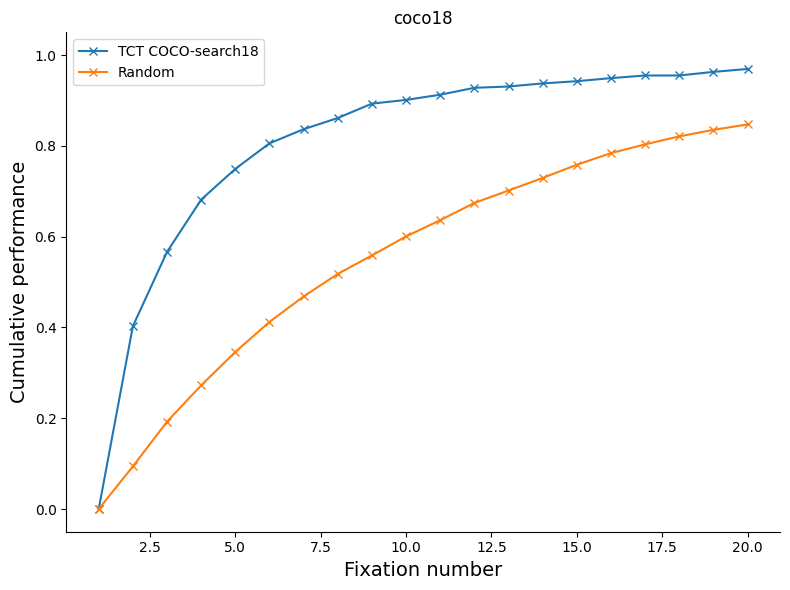

In [14]:
plt.figure(figsize=(8, 6), dpi=100)

for mean, label in zip(avg_cdfs, labels):
    plt.plot(np.arange(1, 21), mean, label=label, marker='x')

plt.ylim([-0.05, 1.05])
plt.legend()
plt.xlabel('Fixation number', fontsize=14)
plt.ylabel('Cumulative performance', fontsize=14)
plt.title(dataset)
plt.legend(loc=2)
sns.despine()
plt.tight_layout()